# Digital Relay Twin Simulation

This notebook simulates digital relay logic using PMU data and FDIA examples.

## 1. Load Data

Load `data/processed/pmu_with_fdia.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../data/processed/pmu_with_fdia.csv')
df.head()

,timestamp,delay_at_arrival,frequency,df/dt,V_a_mag,V_a_ang,I_a_mag,I_a_ang,V_b_mag,V_b_ang,I_b_mag,I_b_ang,V_c_mag,V_c_ang,I_c_mag,I_c_ang,label
0,43469,0.041052,54.382870,0.000494,12250.14062,2.823038,5.967820,3.004401,12274.26172,0.729387,5.257847,0.798279,12217.91211,-1.359533,5.138849,-1.118669,2
1,28475,0.043291,52.882109,0.007034,12094.77344,0.818816,5.787414,1.032419,12126.20312,-1.273829,5.707847,-1.108483,12076.27539,2.919319,5.563178,3.116302,2
2,34621,0.040037,49.955399,0.006925,12342.32227,-0.210893,4.801794,0.004878,12356.16992,-2.304394,4.587549,-2.138999,12305.63086,1.890497,4.518955,2.116505,0
3,83753,0.040402,50.024307,0.021713,12205.69727,-0.437683,6.120511,-0.299975,12236.66699,-2.529933,5.975109,-2.405832,12188.56348,1.663252,6.014031,1.810241,0
4,21523,0.042247,52.157635,0.362751,12121.56445,-0.477642,5.302741,-0.294382,12160.47656,-2.570035,5.235185,-2.479223,12103.96875,1.622697,4.894074,1.762603,2


## 2. Digital Relay Logic Functions

Rule-based logic for TRIP, WAIT, NORMAL decisions.

In [2]:
def relay_decision(row):
    reason = []
    # Example rules (customize as needed)
    if 'I_a_mag' in row:
        if row['I_a_mag'] == 0:
            reason.append('Ia_mag zero')
        elif row['I_a_mag'] > 10000:
            reason.append('Ia_mag very high')
    if 'df/dt' in row and abs(row['df/dt']) > 0.5:
        reason.append('ROCOF spike')
    if 'V_a_ang' in row and abs(row['V_a_ang']) > 2:
        reason.append('Va_angle unusual drift')
    if reason:
        return 'TRIP', '; '.join(reason)
    return 'NORMAL', 'No rule matched'

## 3. Apply Relay Logic and Log Decisions

In [3]:
results = []
for _, row in df.iterrows():
    decision, reason = relay_decision(row)
    results.append({
        'timestamp': row['timestamp'],
        'true_label': row['label'],
        'relay_decision': decision,
        'decision_reason': reason
    })
log_df = pd.DataFrame(results)
log_df.head()

,timestamp,true_label,relay_decision,decision_reason
0,43469.0,2.0,TRIP,Va_angle unusual drift
1,28475.0,2.0,NORMAL,No rule matched
2,34621.0,0.0,NORMAL,No rule matched
3,83753.0,0.0,NORMAL,No rule matched
4,21523.0,2.0,NORMAL,No rule matched


## 4. Compare Relay vs True Labels

In [4]:
from sklearn.metrics import confusion_matrix, classification_report

print('Relay vs True Label Confusion Matrix:')
print(pd.crosstab(log_df['relay_decision'], log_df['true_label'], rownames=['Relay'], colnames=['True']))

# Highlight FDIA cases where relay was fooled
fooled = log_df[(log_df['true_label'] == 2) & (log_df['relay_decision'] != 'TRIP')]
print(f'FDIA cases where relay was fooled: {len(fooled)}')
fooled.head()

Relay vs True Label Confusion Matrix:
True      0.0    1.0     2.0
Relay                       
NORMAL  54737   2978   81775
TRIP    31663  12269  177425
FDIA cases where relay was fooled: 81775


,timestamp,true_label,relay_decision,decision_reason
1,28475.0,2.0,NORMAL,No rule matched
4,21523.0,2.0,NORMAL,No rule matched
7,63437.0,2.0,NORMAL,No rule matched
8,32120.0,2.0,NORMAL,No rule matched
9,43533.0,2.0,NORMAL,No rule matched


## 5. Simulate Real-Time Relay Response

In [5]:
# Simulate a time series stream (first 1000 rows)
for i, row in log_df.head(1000).iterrows():
    print(f"Step {i}: Time {row['timestamp']} | Decision: {row['relay_decision']} | Reason: {row['decision_reason']}")
    # Add a break or sleep if you want to slow down

Step 0: Time 43469.0 | Decision: TRIP | Reason: Va_angle unusual drift
Step 1: Time 28475.0 | Decision: NORMAL | Reason: No rule matched
Step 2: Time 34621.0 | Decision: NORMAL | Reason: No rule matched
Step 3: Time 83753.0 | Decision: NORMAL | Reason: No rule matched
Step 4: Time 21523.0 | Decision: NORMAL | Reason: No rule matched
Step 5: Time 66544.0 | Decision: TRIP | Reason: Ia_mag zero
Step 6: Time 11366.0 | Decision: TRIP | Reason: Ia_mag zero
Step 7: Time 63437.0 | Decision: NORMAL | Reason: No rule matched
Step 8: Time 32120.0 | Decision: NORMAL | Reason: No rule matched
Step 9: Time 43533.0 | Decision: NORMAL | Reason: No rule matched
Step 10: Time 56884.0 | Decision: TRIP | Reason: Ia_mag zero; Va_angle unusual drift
Step 11: Time 63587.0 | Decision: TRIP | Reason: Va_angle unusual drift
Step 12: Time 77453.0 | Decision: TRIP | Reason: Ia_mag zero; Va_angle unusual drift
Step 13: Time 63528.0 | Decision: TRIP | Reason: Va_angle unusual drift
Step 14: Time 17892.0 | Decision:

## 6. Save Results

In [6]:
import os
os.makedirs('../results', exist_ok=True)
log_df.to_csv('../results/relay_simulation_log.csv', index=False)
print('Results saved to ../results/relay_simulation_log.csv')

Results saved to ../results/relay_simulation_log.csv


## 7. Visualizations

Relay trip timeline and relay decision vs true label.

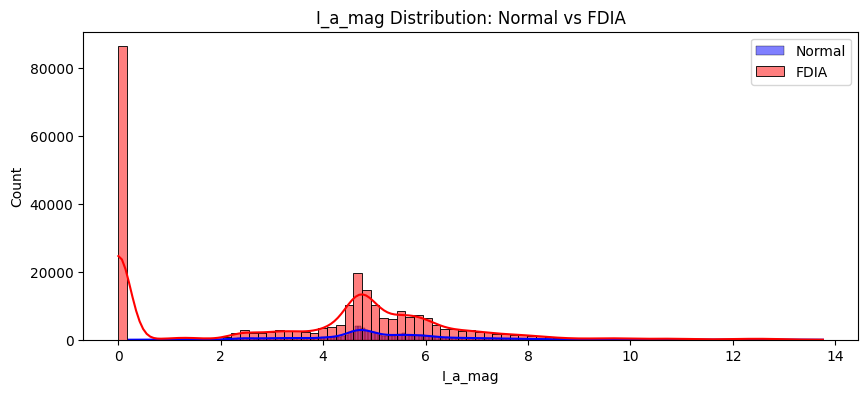

In [11]:
# 1. Compare a feature before/after FDIA
plt.figure(figsize=(10, 4))
sns.histplot(df[df['label']==0]['I_a_mag'], color='blue', label='Normal', kde=True)
sns.histplot(df[df['label']==2]['I_a_mag'], color='red', label='FDIA', kde=True)
plt.legend()
plt.title('I_a_mag Distribution: Normal vs FDIA')
plt.show()



OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 1200x300 with 1 Axes>

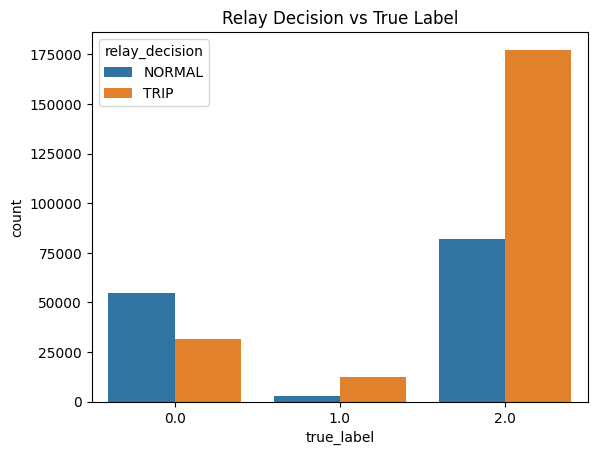

In [10]:
import seaborn as sns

# 1. Relay trip timeline
plt.figure(figsize=(12,3))
plt.plot(log_df['timestamp'], log_df['relay_decision'] == 'TRIP', label='TRIP')
plt.xlabel('Timestamp'); plt.ylabel('TRIP (1=True)')
plt.title('Relay Trip Timeline')
plt.show()

# 2. Relay decision vs true label
sns.countplot(x='true_label', hue='relay_decision', data=log_df)
plt.title('Relay Decision vs True Label')
plt.show()